# Lib Import

In [129]:
import kagglehub

import torch
import torchvision
from torchvision.models.detection.ssd import SSD300_VGG16_Weights
from torchvision.transforms import v2
from torch.utils.data import Dataset
from PIL import Image

import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split

import os
import cv2
import xml.etree.ElementTree as ET

from termcolor import colored


import shutil
from pathlib import Path
from collections import Counter

# Set GPU

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Load Dataset

In [5]:
BASE_DIR = Path().resolve().parent.parent
DATA_DIR = BASE_DIR / 'common' / 'data'

source_path = kagglehub.dataset_download("zippyz/cats-and-dogs-breeds-classification-oxford-dataset")

DATA_DIR = BASE_DIR / 'common' / 'data' / "cats_and_dogs_dataset"

if not DATA_DIR.exists():
    shutil.copytree(source_path, DATA_DIR)
    print(f"✅ 데이터셋 복사 완료: {DATA_DIR}")
else:
    print(f"ℹ️ 이미 데이터셋이 존재합니다: {DATA_DIR}")

ℹ️ 이미 데이터셋이 존재합니다: /Users/carki/Desktop/Dev/codeit/common/data/cats_and_dogs_dataset


In [ ]:
TRAIN_FILE_NAME = "trainval.txt"
TEST_FILE_NAME = "test.txt"

# 파일 경로 설정
trainval_file_path = os.path.join(DATA_DIR, "annotations", "annotations", TRAIN_FILE_NAME)
test_file_path = os.path.join(DATA_DIR, "annotations", "annotations", TEST_FILE_NAME)

# 이미지, Annotation 경로 설정
image_dir = os.path.join(DATA_DIR, "images", "images")
xml_dir = os.path.join(DATA_DIR, "annotations", "annotations", "xmls")

# Train/Validation 파일 읽기
df_trainval = pd.read_csv(trainval_file_path, sep=r"\s+", header=None)
df_trainval.columns = ["Image", "ClassID", "Species", "BreedID"]

# Test 파일 읽기
df_test = pd.read_csv(test_file_path, sep=r"\s+", header=None)
df_test.columns = ["Image", "ClassID", "Species", "BreedID"]

# 데이터 크기 확인
print(f"Train/Validation 데이터 수: {len(df_trainval)}")
print(f"Test 데이터 수: {len(df_test)}")

# Annotation 개수 확인
xml_files = [file for file in os.listdir(xml_dir) if file.endswith(".xml")]
print(f"XML 파일 개수: {len(xml_files)}")

Train/Validation 데이터 수: 3680
Test 데이터 수: 3669
XML 파일 개수: 3686


In [109]:
# Train과 Validation에 사용될 이미지 파일 이름 리스트 생성
trainval_list = df_trainval['Image'].tolist()

# Test에 사용될 이미지 파일 이름 리스트 생성
test_list = df_test['Image'].tolist()

## [func] Check for missing images

In [110]:
xml_list = [os.path.splitext(file)[0] for file in os.listdir(xml_dir) if file.endswith(".xml")]

def get_missing_image_count(image_names, desc = None):
    """
    Args:
        image_names: all image name in df
        desc: (Optional) file name
    """
    
    # XML이 존재하지 않는 이미지 이름 찾기
    missing_xml = [img for img in image_names if img not in xml_list]
    
    prefix = f"{colored(desc, 'yellow')}파일 내에서 " if desc else ""
    
    print(f"{prefix}XML에 없는 이미지 수: {len(missing_xml)}")
    print("누락 이미지 >>>>> ", missing_xml[:len(missing_xml)])
    
    return len(missing_xml)
    

In [111]:
missing_xml_count = get_missing_image_count(trainval_list, f'"{TRAIN_FILE_NAME}"')

"trainval.txt"파일 내에서 XML에 없는 이미지 수: 9
누락 이미지 >>>>>  ['Abyssinian_104', 'Bengal_111', 'samoyed_10', 'Bengal_175', 'Egyptian_Mau_14', 'Egyptian_Mau_156', 'Egyptian_Mau_186', 'Ragdoll_199', 'saint_bernard_15']


## [func] Check for duplicate images
데이터 중복 확인을 위한 함수

In [112]:
def get_duplicated_images_counter(image_names):
    dup_images = [item for item, count in Counter(image_names).items() if count > 1]
    print(f"중복된 이미지 수: {len(dup_images)}")

In [113]:
get_duplicated_images_counter(trainval_list)

중복된 이미지 수: 0


## Update trainval Data

In [114]:
print(f'누락 제거 전 개수: {len(trainval_list)}')
print(f'누락 이미지 개수: {missing_xml_count}')
trainval_list = [image for image in trainval_list if image in xml_list]
print(f'누락 제거 후 개수: {len(trainval_list)}')

print(len(trainval_list))

누락 제거 전 개수: 3680
누락 이미지 개수: 9
누락 제거 후 개수: 3671
3671


## Check dataset

In [12]:
print(df_trainval.shape)
df_trainval.head()

(3680, 4)


,Image,ClassID,Species,BreedID
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [13]:
print(df_test.shape)
df_test.head()

(3669, 4)


,Image,ClassID,Species,BreedID
0,Abyssinian_201,1,1,1
1,Abyssinian_202,1,1,1
2,Abyssinian_204,1,1,1
3,Abyssinian_205,1,1,1
4,Abyssinian_206,1,1,1


In [14]:
df_trainval['Species'].value_counts()

Species
2    2492
1    1188
Name: count, dtype: int64

In [15]:
df_test['Species'].value_counts()

Species
2    2486
1    1183
Name: count, dtype: int64

# Testing Object Detection

## all xml info to annotation

아래 코드가 오른쪽 파일 getitem과 중복되니 이거 해결

In [16]:
all_annotations = []

for xml_file in xml_files:
    xml_path = os.path.join(xml_dir, xml_file)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    image_name = root.find("filename").text

    for obj in root.findall("object"):
        class_name = obj.find("name").text
        bndbox = obj.find("bndbox")
        x_min = int(bndbox.find("xmin").text)
        y_min = int(bndbox.find("ymin").text)
        x_max = int(bndbox.find("xmax").text)
        y_max = int(bndbox.find("ymax").text)

        all_annotations.append({
            "image": image_name,
            "class": class_name,
            "bbox": [x_min, y_min, x_max, y_max]
        })
        
print(all_annotations)

[{'image': 'British_Shorthair_10.jpg', 'class': 'cat', 'bbox': [83, 29, 197, 142]}, {'image': 'german_shorthaired_119.jpg', 'class': 'dog', 'bbox': [128, 22, 240, 222]}, {'image': 'english_setter_158.jpg', 'class': 'dog', 'bbox': [97, 35, 304, 199]}, {'image': 'Siamese_178.jpg', 'class': 'cat', 'bbox': [32, 18, 363, 369]}, {'image': 'pomeranian_162.jpg', 'class': 'dog', 'bbox': [19, 32, 123, 129]}, {'image': 'newfoundland_137.jpg', 'class': 'dog', 'bbox': [105, 30, 362, 286]}, {'image': 'Siamese_150.jpg', 'class': 'cat', 'bbox': [300, 2, 489, 204]}, {'image': 'german_shorthaired_131.jpg', 'class': 'dog', 'bbox': [90, 209, 246, 357]}, {'image': 'english_setter_170.jpg', 'class': 'dog', 'bbox': [214, 67, 337, 217]}, {'image': 'english_setter_164.jpg', 'class': 'dog', 'bbox': [178, 127, 307, 294]}, {'image': 'german_shorthaired_125.jpg', 'class': 'dog', 'bbox': [157, 56, 264, 116]}, {'image': 'Siamese_144.jpg', 'class': 'cat', 'bbox': [160, 21, 340, 230]}, {'image': 'pomeranian_176.jpg', 

## [func] get image annotation

In [17]:
def get_image_annotation(image_name):
    """
    특정 이미지에 해당하는 annotation들을 리스트로 반환
    """
    result = [ann for ann in all_annotations if ann["image"] == image_name + ".jpg"]
    
    return result

## [func] show image

In [18]:
def show_image(image, image_name):
    plt.imshow(image)
    plt.title(f"Image: {image_name}")
    plt.axis("off")
    plt.show()

## [func] Draw Bounding Box

In [ ]:
def draw_bounding_box(annotations, 
                      image, 
                      box_color=(255, 0, 0), 
                      text_color=(255, 0, 0), 
                      text_background_color=(0, 0, 0)):
    
    FONT = cv2.FONT_HERSHEY_SIMPLEX
    FONT_SCALE = 1
    THICKNESS = 2
    
    for anno in annotations:
        class_name = anno["class"]
        x_min, y_min, x_max, y_max = anno["bbox"]
        
        # bbox
        cv2.rectangle(img=image, 
                      pt1=(x_min, y_min), 
                      pt2=(x_max, y_max), 
                      color=box_color,
                      thickness=2)
        
        (text_width, text_height), baseline = cv2.getTextSize(class_name, FONT, FONT_SCALE, THICKNESS)
        
        # Background rectangle
        text_offset_x = x_min
        text_offset_y = y_min - 5 if y_min - 5 - text_height > 0 else y_min + text_height + 5
        box_coords = ((text_offset_x, text_offset_y - text_height - baseline), 
                      (text_offset_x + text_width, text_offset_y))
        
        # Text background rectangle
        cv2.rectangle(image, 
                      pt1=box_coords[0], 
                      pt2=box_coords[1], 
                      color=text_background_color, 
                      thickness=cv2.FILLED)
        
        cv2.putText(img=image, 
                    text=class_name, 
                    org=(text_offset_x, text_offset_y - baseline), 
                    fontFace=FONT, 
                    fontScale=FONT_SCALE, 
                    color=text_color, 
                    thickness=THICKNESS)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [20]:
# Test 데이터에서 예제 이미지 불러오기
test_example_image_name = df_test["Image"].iloc[0]
test_image_path = os.path.join(image_dir, f"{test_example_image_name}.jpg")

# 이미지 읽기
test_image = cv2.imread(test_image_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

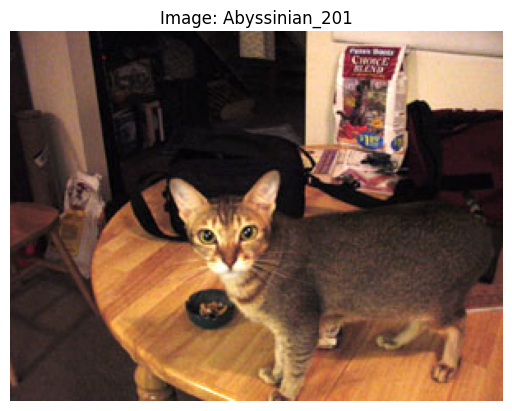

In [22]:
show_image(test_image, test_example_image_name)

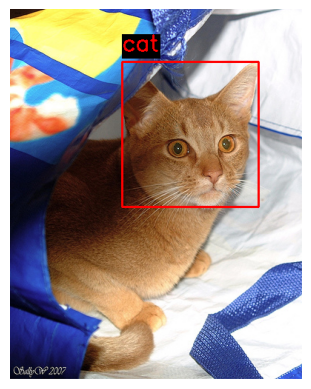

[{'image': 'Abyssinian_100.jpg', 'class': 'cat', 'bbox': [151, 71, 335, 267]}]


In [51]:
# Train 데이터에서 예제 이미지 불러오기
train_example_image_name = df_trainval["Image"].iloc[0]
train_image_path = os.path.join(image_dir, f"{train_example_image_name}.jpg")

# 이미지 읽기
image = cv2.imread(train_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 해당 이미지의 어노테이션 가져오기
annotations = get_image_annotation(train_example_image_name)

draw_bounding_box(annotations=annotations, image=image)

print(annotations)

# Data preprocessing

In [24]:
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True),
    ]
)

# Load Datasets
PASCAL VOC 스타일의 데이터셋을 처리할 수 있는 Dataset 클래스 (XML + 이미지)

In [53]:
class VOCDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, classes, image_list, transforms=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.classes = classes
        self.transforms = transforms
        self.image_files = image_list # 미리 필터링된 유효한 이미지 파일 리스트

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # 이미지 및 XML 파일 경로 설정
        image_file = self.image_files[idx] + ".jpg"
        annotation_file = self.image_files[idx] + ".xml"
        image_path = os.path.join(self.image_dir, image_file)
        annotation_path = os.path.join(self.annotation_dir, annotation_file)

        # 이미지 로드
        image = Image.open(image_path).convert("RGB")

        # 어노테이션 로드
        boxes = []
        labels = []
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        for obj in root.findall("object"):
            class_name = obj.find("name").text
            if class_name not in self.classes:
                continue
            labels.append(self.classes.index(class_name))

            bndbox = obj.find("bndbox")
            x_min = int(bndbox.find("xmin").text)
            y_min = int(bndbox.find("ymin").text)
            x_max = int(bndbox.find("xmax").text)
            y_max = int(bndbox.find("ymax").text)
            boxes.append([x_min, y_min, x_max, y_max])

        # Tensor로 변환
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        # Transform 적용
        if self.transforms:
            image, boxes, labels = self.transforms(image, boxes, labels)

        target = {"boxes": boxes, "labels": labels}
        return image, target

In [54]:
class TestDataset(Dataset):
    def __init__(self, image_dir, image_list, transforms=None):
        self.image_dir = image_dir
        self.transforms = transforms
        self.image_files = image_list  # 테스트 이미지 리스트 (확장자 없음)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # 이미지 파일 경로
        image_file = self.image_files[idx] + ".jpg"
        image_path = os.path.join(self.image_dir, image_file)

        # 이미지 로드
        image = Image.open(image_path).convert("RGB")

        # Transform 적용
        if self.transforms:
            image = self.transforms(image)

        return image, self.image_files[idx]  # 이미지와 파일 이름 반환

In [ ]:
train_list, valid_list = train_test_split(trainval_list, test_size=0.3, random_state=42)

# 결과 확인
print(f"Train 이미지 수: {len(train_list)}")
print(f"Validation 이미지 수: {len(valid_list)}")
print(f"Test 이미지 수: {len(df_test)}")

Train 이미지 수: 2569
Validation 이미지 수: 1102
Test 이미지 수: 3669


In [117]:
from torch.utils.data import DataLoader

# 클래스 정의
CLASSES = ["background", "dog", "cat"]

# Train Dataset
train_dataset = VOCDataset(
    image_dir=image_dir,
    annotation_dir=xml_dir,
    classes=CLASSES,
    image_list=train_list,  # Train 리스트 사용
    transforms=transform
)

# Validation Dataset
valid_dataset = VOCDataset(
    image_dir=image_dir,
    annotation_dir=xml_dir,
    classes=CLASSES,
    image_list=valid_list,  # Validation 리스트 사용
    transforms=transform
)

# Test Dataset 생성
test_dataset = TestDataset(
    image_dir=image_dir,  # 테스트 이미지 디렉토리
    image_list=test_list,       # 테스트 이미지 리스트 (확장자 없는 이름)
    transforms=transform  # 필요하면 Transform 적용
)


# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# 데이터 크기 출력
print(f"Train 데이터셋 크기: {len(train_dataset)}")
print(f"Validation 데이터셋 크기: {len(valid_dataset)}")
print(f"Test 데이터셋 크기: {len(test_dataset)}")


Train 데이터셋 크기: 2569
Validation 데이터셋 크기: 1102
Test 데이터셋 크기: 3669


# Modeling - SSD

In [120]:
# SSD 모델 불러오기
model = torchvision.models.detection.ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT).to(device)

# 클래스 개수에 맞게 출력 레이어 수정
NUM_CLASSES = len(CLASSES)  # background 포함
model.head.classification_head.num_classes = NUM_CLASSES

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /Users/carki/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth


100%|██████████| 136M/136M [00:13<00:00, 10.7MB/s] 


# Training

## [func] Calculate IOU

In [124]:
import numpy as np 

def calculate_iou(cand_box, gt_box):

    # Calculate intersection areas
    x1 = np.maximum(cand_box[0], gt_box[0])
    y1 = np.maximum(cand_box[1], gt_box[1])
    x2 = np.minimum(cand_box[2], gt_box[2])
    y2 = np.minimum(cand_box[3], gt_box[3])
    
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    
    cand_box_area = (cand_box[2] - cand_box[0]) * (cand_box[3] - cand_box[1])
    gt_box_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    union = cand_box_area + gt_box_area - intersection
    
    # 박스가 겹치는 영역 / 전체 면적
    iou = intersection / union
    
    return iou

## [func] Calculate AP
단일 클래스에 대한 AP 계산

In [125]:
def calculate_ap(predictions, ground_truths, class_idx, iou_threshold=0.5):
    """
    특정 클래스에 대한 AP 계산.
    predictions: 모델의 예측 리스트 [{"boxes": [[x_min, y_min, x_max, y_max]], "labels": [label]}]
    ground_truths: 정답 리스트 [{"boxes": [[x_min, y_min, x_max, y_max]], "labels": [label]}]
    class_idx: 평가 대상 클래스 인덱스
    iou_threshold: IoU 기준값 (default=0.5)

    Returns:
        Average Precision (AP) 값
    """
    true_positives = []
    false_positives = []
    all_ground_truths = 0

    # 모든 예측과 정답을 순회
    for pred, gt in zip(predictions, ground_truths):
        pred_boxes = np.array(pred["boxes"])
        pred_labels = np.array(pred["labels"])
        gt_boxes = np.array(gt["boxes"])
        gt_labels = np.array(gt["labels"])

        # 현재 클래스에 해당하는 박스만 필터링
        pred_boxes = pred_boxes[pred_labels == class_idx]
        gt_boxes = gt_boxes[gt_labels == class_idx]

        all_ground_truths += len(gt_boxes)

        # IoU 계산
        detected = []
        for pred_box in pred_boxes:
            ious = []
            for gt_box in gt_boxes:
                iou = calculate_iou(pred_box, gt_box)
                ious.append(iou)

            if len(ious) > 0:
                max_iou_idx = np.argmax(ious)
                if ious[max_iou_idx] >= iou_threshold and max_iou_idx not in detected:
                    true_positives.append(1)
                    false_positives.append(0)
                    detected.append(max_iou_idx)
                else:
                    true_positives.append(0)
                    false_positives.append(1)
            else:
                false_positives.append(1)

    # Precision-Recall Curve 계산
    tp_cumsum = np.cumsum(true_positives)
    fp_cumsum = np.cumsum(false_positives)
    precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
    recalls = tp_cumsum / (all_ground_truths + 1e-6)

    # AP 계산
    ap = 0.0
    for i in range(1, len(precisions)):
        ap += (recalls[i] - recalls[i - 1]) * precisions[i]

    return ap

## [func] Evaluate Model

In [126]:
def evaluate_model(predictions, ground_truths, classes):
    class_aps = []

    for class_idx, class_name in enumerate(classes[1:], start=1):
        true_positives = []
        scores = []
        num_ground_truths = 0

        for pred, gt in zip(predictions, ground_truths):
            # Filter for the current class
            pred_boxes = pred["boxes"][pred["labels"] == class_idx].cpu().numpy() if len(pred["boxes"]) > 0 else []
            pred_scores = pred["scores"][pred["labels"] == class_idx].cpu().numpy() if len(pred["scores"]) > 0 else []
            gt_boxes = gt["boxes"][gt["labels"] == class_idx].cpu().numpy() if len(gt["boxes"]) > 0 else []

            num_ground_truths += len(gt_boxes)

            if len(pred_boxes) == 0 or len(gt_boxes) == 0:
                continue  # Skip if no predictions or ground truths for this class

            matched = np.zeros(len(gt_boxes), dtype=bool)
            for box, score in zip(pred_boxes, pred_scores):
                ious = calculate_iou(box, gt_boxes)
                max_iou_idx = np.argmax(ious) if len(ious) > 0 else -1
                max_iou = ious[max_iou_idx] if max_iou_idx >= 0 else 0

                if max_iou >= 0.5 and not matched[max_iou_idx]:
                    true_positives.append(1)
                    matched[max_iou_idx] = True
                else:
                    true_positives.append(0)

                scores.append(score)

        if len(scores) == 0:
            class_aps.append(0)
            continue

        sorted_indices = np.argsort(-np.array(scores))
        true_positives = np.array(true_positives)[sorted_indices]
        scores = np.array(scores)[sorted_indices]

        cum_true_positives = np.cumsum(true_positives)
        precision = cum_true_positives / (np.arange(len(true_positives)) + 1)
        recall = cum_true_positives / num_ground_truths

        ap = average_precision_score(true_positives, scores) if len(scores) > 0 else 0
        class_aps.append(ap)

    mAP = np.mean(class_aps)
    return mAP

## Optimizer & Loss

In [127]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs} 시작")

    # Training Phase
    model.train()
    total_train_loss = 0

    for images, targets in tqdm(train_loader, desc="Training"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_train_loss += losses.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

    # Validation Phase
    model.eval()
    all_predictions = []
    all_ground_truths = []

    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc="Validation"):
            images = [img.to(device) for img in images]
            predictions = model(images)

            # 저장: 추론 결과와 Ground Truth
            all_predictions.extend(predictions)
            all_ground_truths.extend(targets)

    # 성능 평가 (예: mAP 계산)
    mAP = evaluate_model(all_predictions, all_ground_truths, CLASSES)
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation mAP: {mAP:.4f}\n")

# Model Prediction & Visualize

In [130]:
def visualize_prediction(image, prediction, classes):
    """
    image (torch.Tensor): 추론에 사용된 이미지 (C, H, W 형식).
    prediction (dict): 모델의 예측 결과 (boxes, labels, scores 포함).
    classes (list): 클래스 이름 리스트.
    """
    # Tensor 이미지를 (H, W, C) 형식으로 변환
    image = image.permute(1, 2, 0).numpy()

    # Matplotlib을 사용한 이미지 시각화
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    # Bounding Box와 클래스 이름 시각화
    for box, label, score in zip(prediction["boxes"], prediction["labels"], prediction["scores"]):
        if score > 0.5:  # Confidence Score 임계값
            x_min, y_min, x_max, y_max = box.tolist()
            width, height = x_max - x_min, y_max - y_min

            # Bounding Box 추가
            rect = patches.Rectangle(
                (x_min, y_min), width, height, linewidth=2, edgecolor="red", facecolor="none"
            )
            ax.add_patch(rect)

            # 클래스 이름과 Confidence Score 추가
            ax.text(
                x_min,
                y_min - 10,
                f"{classes[label]}: {score:.2f}",
                color="red",
                fontsize=10,
                bbox=dict(facecolor="white", alpha=0.7),
            )

    plt.axis("off")
    plt.show()

In [ ]:
model.eval()
max_visualizations = 10  # 최대 시각화 개수 설정
count = 0

with torch.no_grad():
    for images, image_files in tqdm(test_loader, desc="Test Inference"):
        images = [img.to(device) for img in images]
        predictions = model(images)

        for img, pred, file_name in zip(images, predictions, image_files):
            if count >= max_visualizations:
                break  # 최대 개수 초과 시 중단

            print(f"Processing: {file_name}")
            visualize_prediction(img.cpu(), pred, classes)
            count += 1

        if count >= max_visualizations:
            break  # 루프 종료